# AI LAB 4: TRANSFER LEARNING

**Vgg-19 Multiclass Classification**


### Библиотеки и установка зависимостей

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
DATA_MODES = ['train', 'val']
RESCALE_SIZE = 224
DEVICE = torch.device("cpu")
BIN = False
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")

In [3]:
def checkBin(filename):
    if filename[0].islower():
        return "Dog"
    return "Cat"

In [4]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, bin=False):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.bin = bin

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.bin:
                self.labels = [checkBin(path.name) for path in self.files]
            else:
                self.labels = ["_".join(path.name.split("_")[0:-1]) for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAutocontrast(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
root = './'
_ = OxfordIIITPet(root, download=True)

100%|██████████| 791918971/791918971 [00:07<00:00, 100575429.17it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 77131602.94it/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [7]:
DIR = Path('./oxford-iiit-pet/images')

files = sorted(list(DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

if BIN:
    y = [checkBin(path.name) for path in files]
else:
    y = ["_".join(path.name.split("_")[0:-1]) for path in files]
print(y)

train_data, val_data = train_test_split(files, train_size=0.8, stratify=y)

['Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abyssinian', 'Abys

In [9]:
train_dataset = PetFacesDataset(train_data, "train", bin=BIN)
val_dataset   = PetFacesDataset(val_data, "val", bin=BIN)

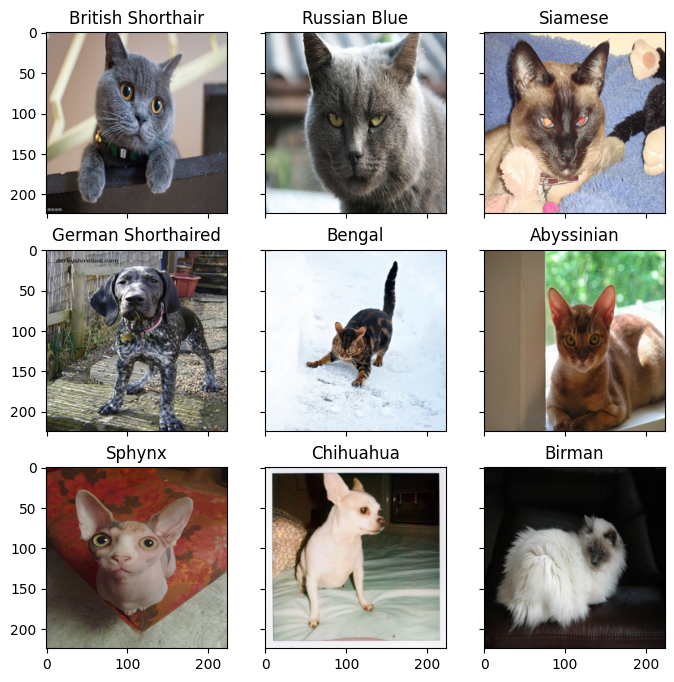

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Код для обучения модели

In [11]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0.0
    processed_data = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects_top3 = 0.0
    running_corrects_top5 = 0.0
    processed_size = 0.0
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            preds_top3 = preds
            preds_top5 = preds
            try:
                preds_top3 = torch.topk(outputs, 3).indices
                preds_top5 = torch.topk(outputs, 5).indices
            except:
                "ok"
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top3[i]:
                running_corrects_top3 += 1
                # print(labels.data[i])
                # print(preds_top3[i])
        for i in range(len(labels.data)):
            if labels.data[i] in preds_top5[i]:
                running_corrects_top5 += 1
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double().cpu().numpy() / processed_size
    val_acc_top3 = running_corrects_top3 / processed_size
    val_acc_top5 = running_corrects_top5 / processed_size
    return val_loss, val_acc, val_acc_top3, val_acc_top5

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} \
    train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} \
    val_acc_top3 {v_acc_3:0.4f} val_acc_top5 {v_acc_5:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            model.train()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            model.eval()
            val_loss, val_acc, val_acc_3, val_acc_5 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc, val_acc_3, val_acc_5))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
            v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_3=val_acc_3,\
            v_acc_5=val_acc_5))
    return history

In [14]:
def predict(model, test_loader):
    logits = []
    with torch.inference_mode():
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Обучение

Посмотрим на количество данных и число классов.

In [15]:
print(f"Количествово классов: {len(np.unique(np.array(y)))}")
print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Количествово классов: 37
Размер обучающей выборки: 5912
Размер валидационной выборки: 1478


В этом блокноте рассматривается **Vgg-19** для **многоклассовой** классификации

In [16]:
model = torchvision.models.vgg19(weights="IMAGENET1K_V1")
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 68.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Поменяем выход последнего слоя на количество классов (в случае бинарной классификации - 2)

In [17]:
model.classifier[6] = nn.Linear(4096, len(np.unique(np.array(y))))

In [18]:
model = model.to(DEVICE)

Обучаем сеть

In [19]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=128)

epoch:   5%|▌         | 1/20 [03:41<1:10:12, 221.70s/it]


Epoch 001 train_loss: 3.6858 val_loss 3.6138     train_acc 0.0255 val_acc 0.0352     val_acc_top3 0.0900 val_acc_top5 0.1536


epoch:  10%|█         | 2/20 [07:11<1:04:19, 214.40s/it]


Epoch 002 train_loss: 3.6120 val_loss 3.5936     train_acc 0.0296 val_acc 0.0332     val_acc_top3 0.1001 val_acc_top5 0.1509


epoch:  15%|█▌        | 3/20 [10:39<59:56, 211.57s/it]


Epoch 003 train_loss: 3.5852 val_loss 3.5604     train_acc 0.0338 val_acc 0.0419     val_acc_top3 0.1279 val_acc_top5 0.1989


epoch:  20%|██        | 4/20 [14:10<56:24, 211.53s/it]


Epoch 004 train_loss: 3.5254 val_loss 3.5117     train_acc 0.0465 val_acc 0.0514     val_acc_top3 0.1488 val_acc_top5 0.2422


epoch:  25%|██▌       | 5/20 [17:38<52:31, 210.09s/it]


Epoch 005 train_loss: 3.4585 val_loss 3.4741     train_acc 0.0597 val_acc 0.0494     val_acc_top3 0.1637 val_acc_top5 0.2490


epoch:  30%|███       | 6/20 [21:10<49:10, 210.72s/it]


Epoch 006 train_loss: 3.4210 val_loss 3.4423     train_acc 0.0687 val_acc 0.0656     val_acc_top3 0.1570 val_acc_top5 0.2564


epoch:  35%|███▌      | 7/20 [24:42<45:45, 211.18s/it]


Epoch 007 train_loss: 3.4047 val_loss 3.4344     train_acc 0.0694 val_acc 0.0602     val_acc_top3 0.1678 val_acc_top5 0.2740


epoch:  40%|████      | 8/20 [28:13<42:15, 211.31s/it]


Epoch 008 train_loss: 3.3739 val_loss 3.4338     train_acc 0.0729 val_acc 0.0656     val_acc_top3 0.1712 val_acc_top5 0.2639


epoch:  45%|████▌     | 9/20 [31:45<38:45, 211.44s/it]


Epoch 009 train_loss: 3.3541 val_loss 3.4079     train_acc 0.0798 val_acc 0.0656     val_acc_top3 0.1691 val_acc_top5 0.2808


epoch:  50%|█████     | 10/20 [35:17<35:16, 211.68s/it]


Epoch 010 train_loss: 3.3572 val_loss 3.3953     train_acc 0.0792 val_acc 0.0683     val_acc_top3 0.1786 val_acc_top5 0.2984


epoch:  55%|█████▌    | 11/20 [38:49<31:45, 211.70s/it]


Epoch 011 train_loss: 3.3551 val_loss 3.3931     train_acc 0.0771 val_acc 0.0650     val_acc_top3 0.1786 val_acc_top5 0.2963


epoch:  60%|██████    | 12/20 [42:21<28:13, 211.71s/it]


Epoch 012 train_loss: 3.3468 val_loss 3.3879     train_acc 0.0771 val_acc 0.0697     val_acc_top3 0.1827 val_acc_top5 0.3004


epoch:  65%|██████▌   | 13/20 [45:51<24:38, 211.25s/it]


Epoch 013 train_loss: 3.3448 val_loss 3.3880     train_acc 0.0771 val_acc 0.0656     val_acc_top3 0.1827 val_acc_top5 0.3058


epoch:  70%|███████   | 14/20 [49:28<21:17, 212.98s/it]


Epoch 014 train_loss: 3.3478 val_loss 3.3881     train_acc 0.0792 val_acc 0.0643     val_acc_top3 0.1800 val_acc_top5 0.3051


epoch:  75%|███████▌  | 15/20 [53:00<17:43, 212.60s/it]


Epoch 015 train_loss: 3.3507 val_loss 3.3880     train_acc 0.0788 val_acc 0.0643     val_acc_top3 0.1793 val_acc_top5 0.3038


epoch:  80%|████████  | 16/20 [56:32<14:10, 212.65s/it]


Epoch 016 train_loss: 3.3437 val_loss 3.3883     train_acc 0.0800 val_acc 0.0622     val_acc_top3 0.1806 val_acc_top5 0.3045


epoch:  85%|████████▌ | 17/20 [1:00:10<10:42, 214.09s/it]


Epoch 017 train_loss: 3.3397 val_loss 3.3883     train_acc 0.0810 val_acc 0.0616     val_acc_top3 0.1793 val_acc_top5 0.3031


epoch:  90%|█████████ | 18/20 [1:03:43<07:07, 213.71s/it]


Epoch 018 train_loss: 3.3369 val_loss 3.3883     train_acc 0.0805 val_acc 0.0616     val_acc_top3 0.1806 val_acc_top5 0.3031


epoch:  95%|█████████▌| 19/20 [1:07:14<03:33, 213.02s/it]


Epoch 019 train_loss: 3.3414 val_loss 3.3883     train_acc 0.0793 val_acc 0.0616     val_acc_top3 0.1793 val_acc_top5 0.3038


epoch: 100%|██████████| 20/20 [1:10:46<00:00, 212.33s/it]


Epoch 020 train_loss: 3.3392 val_loss 3.3882     train_acc 0.0788 val_acc 0.0616     val_acc_top3 0.1800 val_acc_top5 0.3038


Построим кривые обучения для первых 20 эпох

In [20]:
loss, acc, val_loss, val_acc, val_acc_3, val_acc_5 = zip(*history)

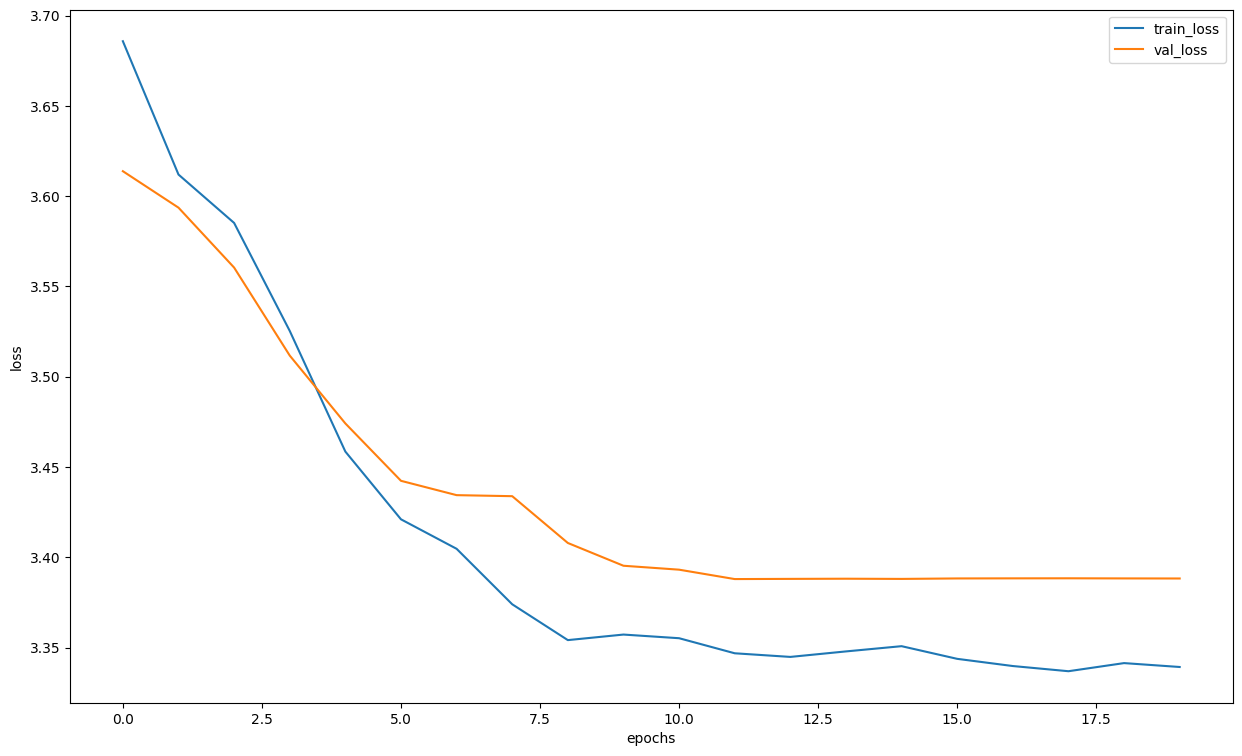

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

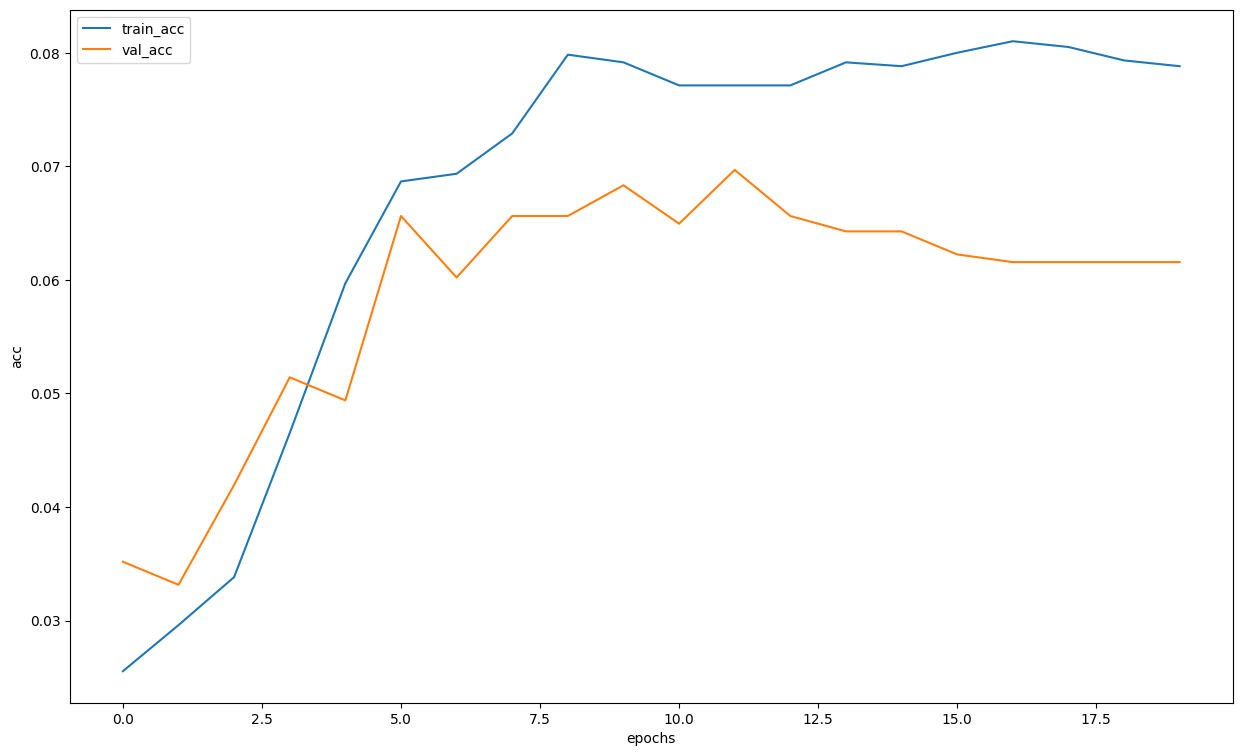

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [23]:
# history2 = train(train_dataset, val_dataset, model=model, epochs=5, batch_size=128)

Визуализация предсказаний нейронной сети

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    with torch.inference_mode():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

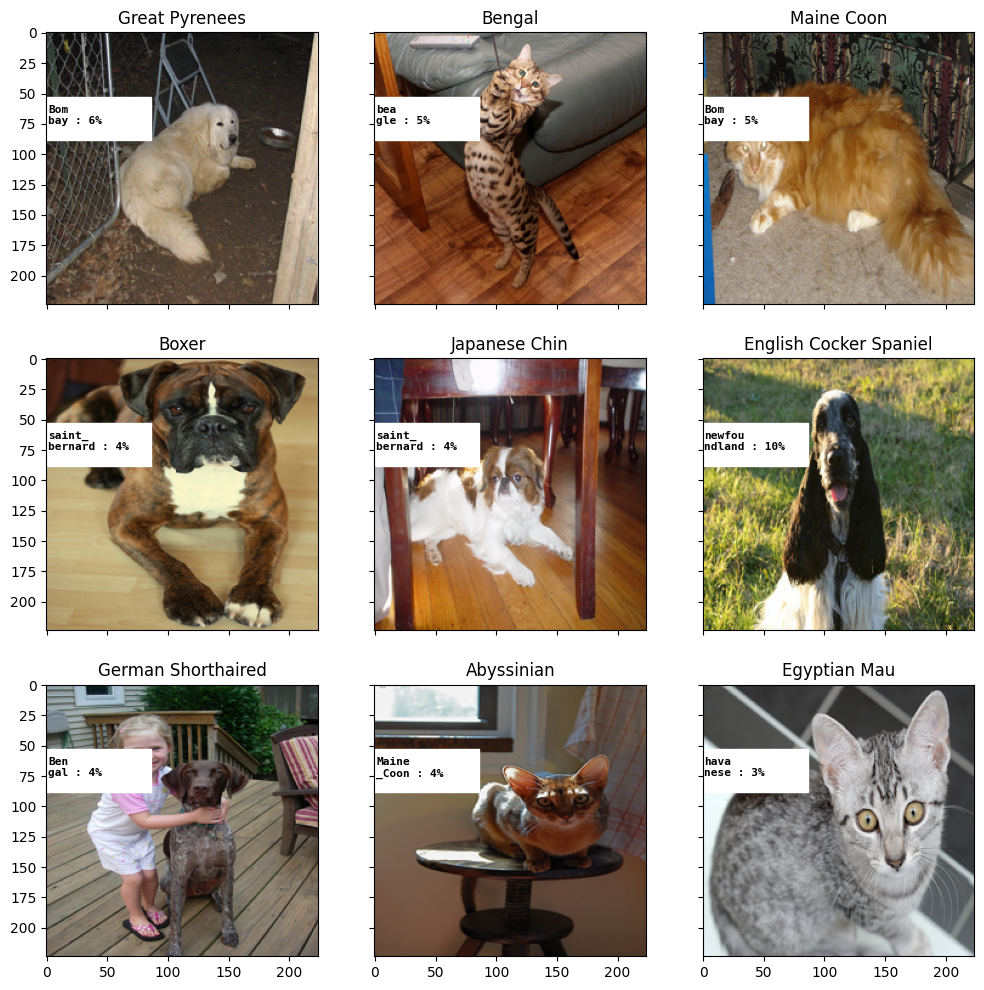

In [25]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53), 86, 35, color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("monospace")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred) * 100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label) // 2] + '\n' + predicted_label[len(predicted_label) // 2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label, predicted_proba)
            
    fig_x.text(1, 59, predicted_text, horizontalalignment='left', fontproperties=font,
                    verticalalignment='top', fontsize=8, color='black', fontweight='bold')

## Confusion matrix

Матрица ошибок (Confusion matrix) --- это важный инструмент, который используется для оценки производительности модели классификации. Она представляет собой таблицу, которая позволяет визуализировать и анализировать результаты классификации на основе истинных и предсказанных значений.

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [27]:
idxs = list(range(0, len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)
y_real = [val_dataset[id][1] for id in idxs]
y_pred = torch.Tensor(probs_ims).argmax(dim=1).tolist()

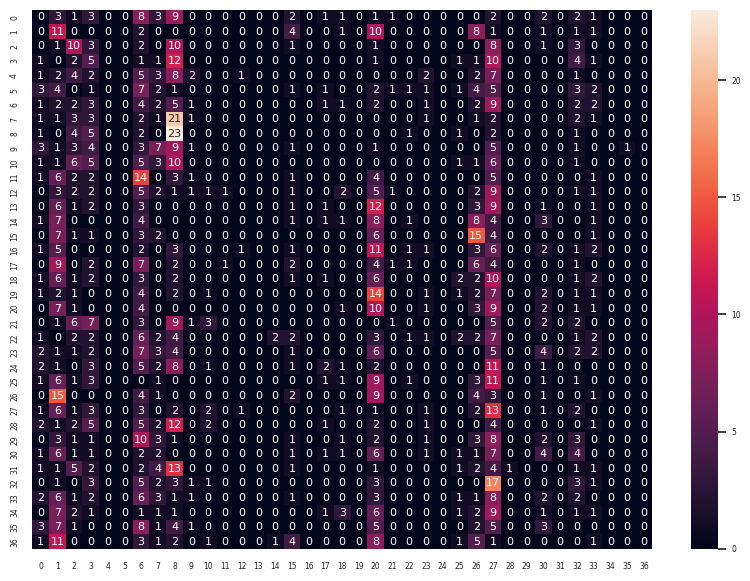

In [28]:
array = confusion_matrix(y_real, y_pred)
df_cm = pd.DataFrame(array, range(37), range(37))
plt.figure(figsize=(10, 7))
sn.set(font_scale=0.5)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})
plt.show()

#### Соотношения классов с лейблами


In [29]:
[x for x in zip(train_dataset.label_encoder.classes_,
train_dataset.label_encoder.transform(list(train_dataset.label_encoder.classes_)))]

[('Abyssinian', 0),
 ('Bengal', 1),
 ('Birman', 2),
 ('Bombay', 3),
 ('British_Shorthair', 4),
 ('Egyptian_Mau', 5),
 ('Maine_Coon', 6),
 ('Persian', 7),
 ('Ragdoll', 8),
 ('Russian_Blue', 9),
 ('Siamese', 10),
 ('Sphynx', 11),
 ('american_bulldog', 12),
 ('american_pit_bull_terrier', 13),
 ('basset_hound', 14),
 ('beagle', 15),
 ('boxer', 16),
 ('chihuahua', 17),
 ('english_cocker_spaniel', 18),
 ('english_setter', 19),
 ('german_shorthaired', 20),
 ('great_pyrenees', 21),
 ('havanese', 22),
 ('japanese_chin', 23),
 ('keeshond', 24),
 ('leonberger', 25),
 ('miniature_pinscher', 26),
 ('newfoundland', 27),
 ('pomeranian', 28),
 ('pug', 29),
 ('saint_bernard', 30),
 ('samoyed', 31),
 ('scottish_terrier', 32),
 ('shiba_inu', 33),
 ('staffordshire_bull_terrier', 34),
 ('wheaten_terrier', 35),
 ('yorkshire_terrier', 36)]